In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from utils import *
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, Flatten, Lambda
from keras import backend as K
from keras.utils import plot_model
plt.style.use('ggplot')

Using TensorFlow backend.


### Gather Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_plotter = plotter(x_train, y_train)
test_plotter = plotter(x_test, y_test)

### Reshape and format data

In [3]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Model Parameters

In [4]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size=128
latent_dim = 2
epochs = 50

### Build Model

In [5]:
inputs = Input(shape=input_shape, name='enc_in')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim//2, activation='relu')(x)
x = Dense(intermediate_dim//4, activation='relu')(x)
mu = Dense(latent_dim, name='mu')(x)
sig = Dense(latent_dim, name='sig')(x)

# reparameterization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, sig])
encoder = Model(inputs, [mu, sig, z], name='enc')
encoder.summary()

dec_inputs = Input(shape=(latent_dim, ), name='dec_in')
x = Dense(intermediate_dim//4, activation='relu')(dec_inputs)
x = Dense(intermediate_dim//2, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(dec_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      enc_in[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       dense_2[0][0]                    
_____________________________________

### VAE Loss Functions

Reconstruction Loss  $ = (x_{true} - x_{reconstruct})^2 $

KL Divergence Loss $ = -\frac{1 + \sigma - \mu^2 - e^{\sigma}}{2} $

In [6]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
kl_loss = -0.5*(K.mean(1 + sig - K.square(mu) - K.exp(sig), axis=-1))
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_in (InputLayer)          (None, 784)               0         
_________________________________________________________________
enc (Model)                  [(None, 2), (None, 2), (N 566660    
_________________________________________________________________
decoder (Model)              (None, 784)               567184    
Total params: 1,133,844
Trainable params: 1,133,844
Non-trainable params: 0
_________________________________________________________________


In [7]:
vae.fit(
    x_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(x_test, None), )

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/35
60000/60000 [==============================] - 13s 221us/step - loss: 0.2743 - val_loss: 0.2635
Epoch 2/35
60000/60000 [==============================] - 13s 216us/step - loss: 0.2635 - val_loss: 0.2632
Epoch 3/35
60000/60000 [==============================] - 13s 209us/step - loss: 0.2634 - val_loss: 0.2631
Epoch 4/35
60000/60000 [==============================] - 13s 219us/step - loss: 0.2633 - val_loss: 0.2631
Epoch 5/35
60000/60000 [==============================] - 13s 215us/step - loss: 0.2632 - val_loss: 0.2628
Epoch 6/35
60000/60000 [==============================] - 16s 265us/step - loss: 0.2631 - val_loss: 0.2627
Epoch 7/35
60000/60000 [==============================] - 14s 242us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 8/35
60000/60000 [==============================] - 16s 265us/step - loss: 0.2631 - val_loss: 0.2627
Epoch 9/35
60000/60000 [======================

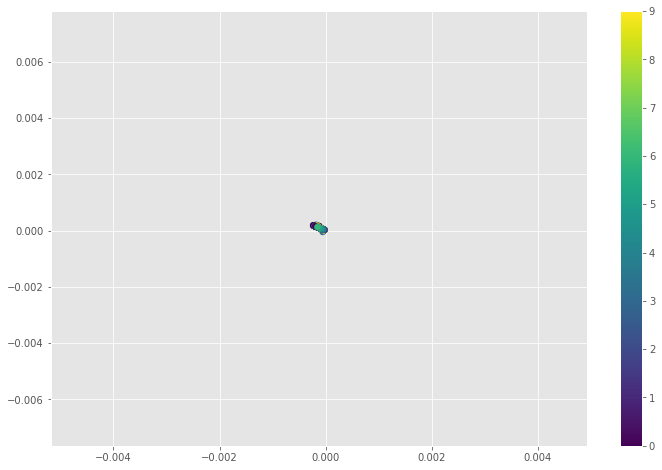

In [8]:
mu, sig, out = encoder.predict(x_test)
plt.figure(figsize=(12,8))
plt.scatter(mu[:,0], mu[:,1], c=y_test)
plt.colorbar()

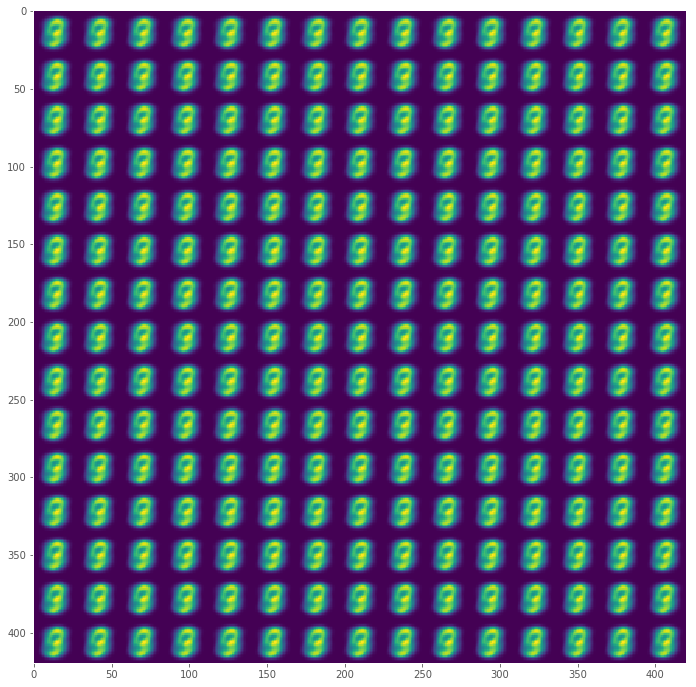

In [9]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-.02, .02, n)
grid_y = np.linspace(-.02, .02, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi,yi]])
        out = decoder.predict(z)
        digit = out[0].reshape(28,28)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(15,12))
plt.grid()
plt.imshow(figure)